---
title: "Exercises"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---

## Tasks

1. Download the paper  
  <a href="/archive/data/nassif-1975-THE-INFLUENCE-OF-SLOPE-AND-RAIN-INTENSITY-ON-RUNOFF-AND-INFILTRATION.pdf" download>Nassif, S. H., and E. M. Wilson, 1975, "The influence of slope and rain intensity on runoff and infiltration", Hydrological Sciences Journal.</a>
1. Google the following: `plot digitizer`
1. Load image "nassif-16percent-slope.png" (see below)
1. Digitize data points from left to right. Create 4 csv files, one for each data set. Call them whatever you want.  
  Legend:  

        * white circle = 312 mm/h,
        * triangle = 234 mm/h,
        * x = 156 mm/h,
        * black circle = 78 mm/h.

The image is the second panel of Fig. 8, from the paper you downloaded.

![](/archive/figures/nassif-16percent-slope.png)

If for any reason you're having trouble digitizing the data from the graph, download here each csv file I have already prepared.

* <a href="input_rate_078mm_per_h_16percent_slope.csv" download>input_rate_078mm_per_h_16percent_slope.csv</a>
* <a href="input_rate_156mm_per_h_16percent_slope.csv" download>input_rate_156mm_per_h_16percent_slope.csv</a>
* <a href="input_rate_234mm_per_h_16percent_slope.csv" download>input_rate_234mm_per_h_16percent_slope.csv</a>
* <a href="input_rate_312mm_per_h_16percent_slope.csv" download>input_rate_312mm_per_h_16percent_slope.csv</a>

Import relevant packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", font_scale=1.5)
from scipy.optimize import curve_fit
import matplotlib.patches as patches

Load all four files you created. Use numpy's function `loadtxt`. Make sure that the first point in each table corresponds to the appropriate rainfall rate. You can normalize the data if it is not.

In [2]:
#| code-fold: false
d1 = np.loadtxt("input_rate_078mm_per_h_16percent_slope.csv", delimiter=',')
d2 = np.loadtxt("input_rate_156mm_per_h_16percent_slope.csv", delimiter=',')
d3 = np.loadtxt("input_rate_234mm_per_h_16percent_slope.csv", delimiter=',')
d4 = np.loadtxt("input_rate_312mm_per_h_16percent_slope.csv", delimiter=',')

"""
In the digitization process, not all points are necessarily
located in the "correct" location. Because we know the initial
infiltration rate for each data series, we can correct that and
rescale the data so that the first point is exactly where we
expect it to be
"""
d1[:,1] = d1[:,1] * 78  / d1[:,1].max()
d2[:,1] = d2[:,1] * 156 / d2[:,1].max()
d3[:,1] = d3[:,1] * 234 / d3[:,1].max()
d4[:,1] = d4[:,1] * 312 / d4[:,1].max()

Reproduce the original figure, make it look good, something like this:

<!-- ![](hydrology_figures/infiltration_rate_1_nassif1975.png) -->

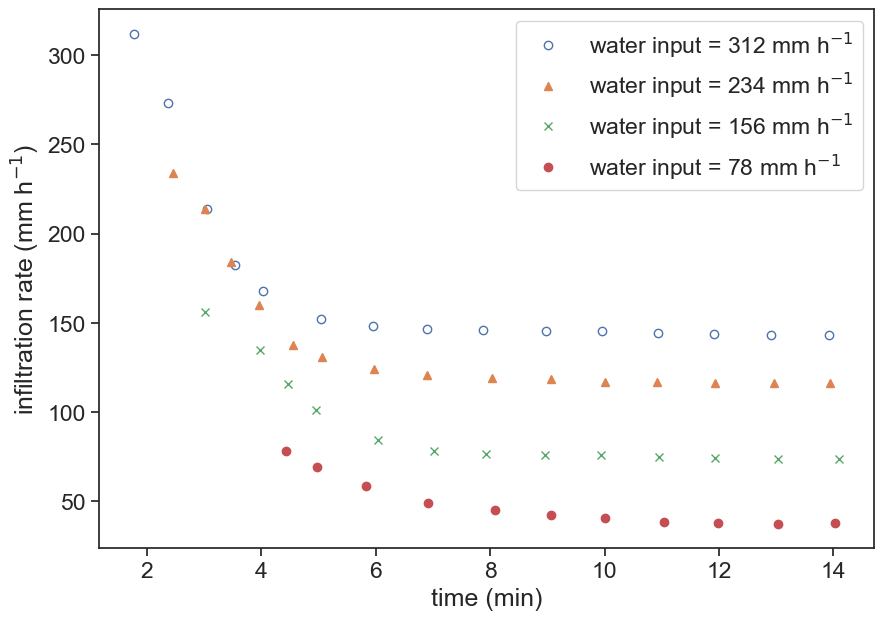

In [3]:
#| code-fold: false
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(d4[:,0], d4[:,1], 'o', markerfacecolor="None", label=r"water input = 312 mm h$^{-1}$")
ax.plot(d3[:,0], d3[:,1], '^', label=r"water input = 234 mm h$^{-1}$")
ax.plot(d2[:,0], d2[:,1], 'x', label=r"water input = 156 mm h$^{-1}$")
ax.plot(d1[:,0], d1[:,1], 'o', label=r"water input = 78 mm h$^{-1}$")
ax.set(xlabel="time (min)",
       ylabel=r"infiltration rate (mm h$^{-1}$)")
ax.legend(loc="upper right");

## Horton's equation

$$
f = f_c+(f_0-f_c)e^{-\beta t}
$$

* $f$: infiltration rate
* $f_c$: infiltration capacity at large $t$
* $f_0$: initial infiltration capacity
* $\beta$: best fit empirical parameter

Write a function called `horton`, that receives time `t` and the three parameters, and returns the right-hand side of the equation above. Plot one of the data sets, together with a guess of the parameters that should **roughly** fit the data.

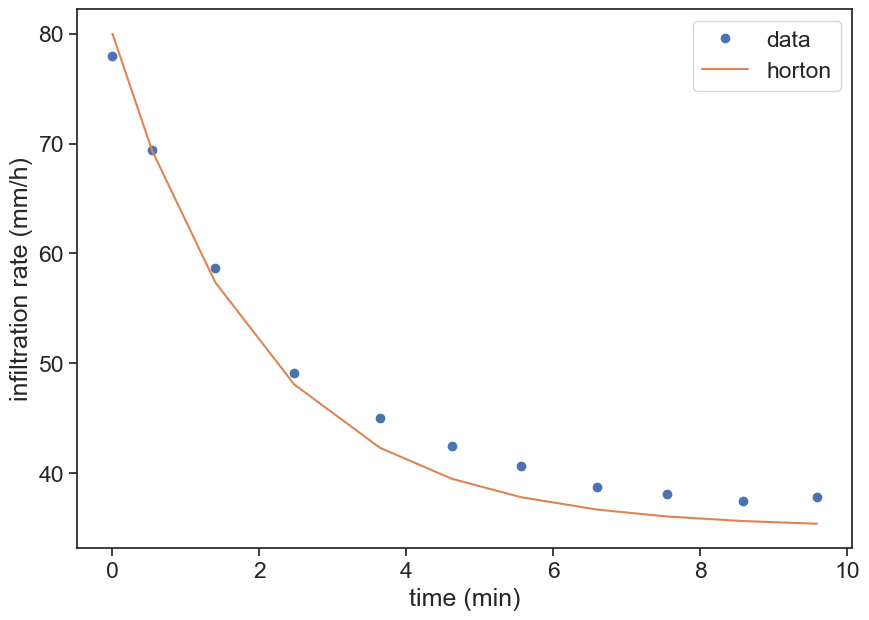

In [4]:
#| code-fold: false
def horton(t, fc, f0, beta):
    return fc + (f0 - fc) * np.exp(-beta*t)

fig, ax = plt.subplots(figsize=(10,7))
t = d1[:,0]
t = t - t[0]
f = d1[:,1]
ax.plot(t, f, 'o', label="data")
param_guess = [35, 80, 0.5]
ax.plot(t, horton(t, *param_guess), '-', label="horton")
ax.set(xlabel="time (min)",
       ylabel="infiltration rate (mm/h)")
ax.legend(loc="upper right");

Find the best fit for the parameters $f_c, f_0, \beta$. Calculate the $R^2$ for each data set.

For the best fit, use scipy's [`curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html). Write a function to compute the R-squared of your fit.

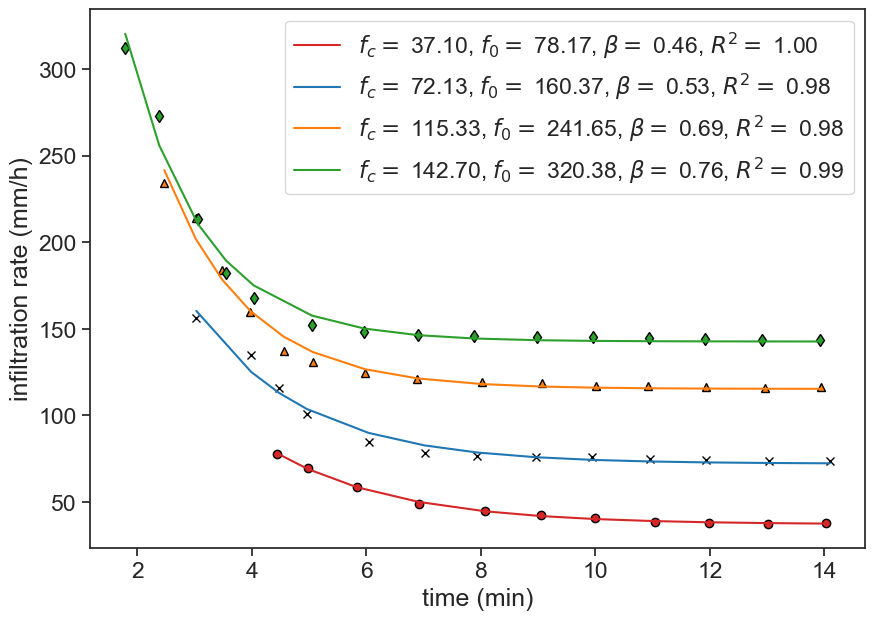

In [5]:
#| code-fold: false

def best_fit(data):
    t = data[:,0]
    t = t - t[0]
    f = data[:,1]
    # best fit
    popt, pcov = curve_fit(f=horton,             # model function
                           xdata=t,              # x data
                           ydata=f,              # y data
                           p0=(130, 800, 0.5),   # initial guess of the parameters
                          )
    return [popt, pcov]

def calculate_r_squared(data, popt):
    t = data[:,0]
    t = t - t[0]
    f = data[:,1]
    # Calculate residuals
    residuals = f - horton(t, *popt)
    # You can get the residual sum of squares (ss_res) with
    ss_res = np.sum(residuals**2)
    # You can get the total sum of squares (ss_tot) with
    ss_tot = np.sum((f - np.mean(f))**2)
    # And finally, the r_squared-value with,
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

def plot_best_fit(data, axis, marker, markercolor):
    # calculate best fit parameters
    popt, pcov = best_fit(data)
    t = data[:,0]
    f = data[:,1]
    # plot data points
    ax.plot(t, f, marker, markerfacecolor=markercolor, markeredgecolor="black")
    # plot best fit line
    r_squared = calculate_r_squared(data, popt)
    labeltext = r"$f_c=$ {:.2f}, $f_0=$ {:.2f}, $\beta=$ {:.2f}, $R^2=$ {:.2f}".format(popt[0],popt[1],popt[2], r_squared)
    ax.plot(t, horton(t-t[0], *popt), color=markercolor, label=labeltext)    

fig, ax = plt.subplots(figsize=(10,7))
plot_best_fit(d1, ax, 'o', "tab:red")
plot_best_fit(d2, ax, 'x', "tab:blue")
plot_best_fit(d3, ax, '^', "tab:orange")
plot_best_fit(d4, ax, 'd', "tab:green")
ax.set(xlabel="time (min)",
       ylabel="infiltration rate (mm/h)")
ax.legend();

Make a graph of the infiltration rate and of the runoff, as a function of time. Use any of the four data sets you have.

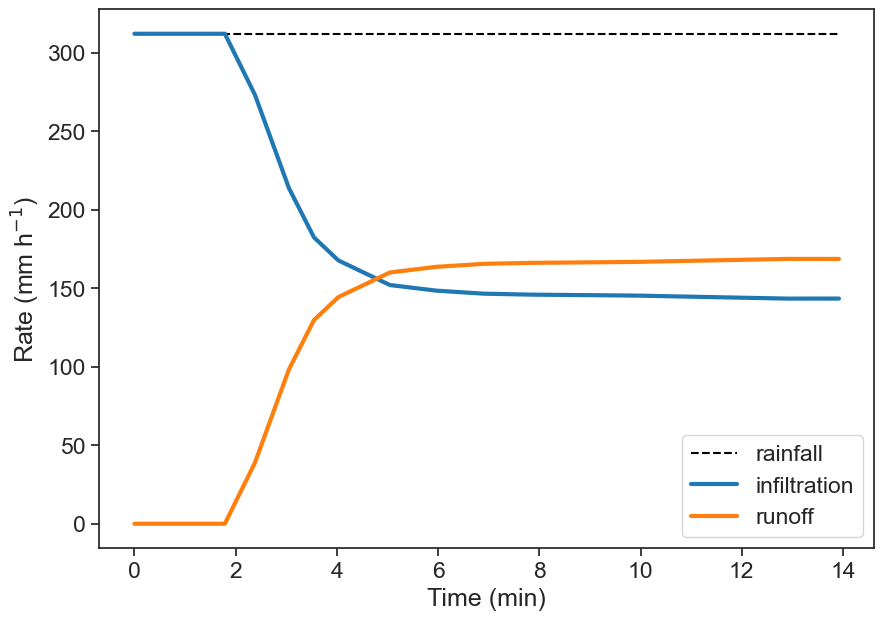

In [6]:
#| code-fold: false

fig, ax = plt.subplots(figsize=(10,7))
data = d4
t = data[:, 0]
f = data[:, 1]
t = np.concatenate([ [0], t])
f = np.concatenate([ [f[0]], f])
runoff = f[0] - f
ax.plot(t, f*0 + f[0], ls="--", color="black", label="rainfall")
ax.plot(t, f, color="tab:blue", lw=3, label=r"infiltration")
ax.plot(t, runoff, color="tab:orange", lw=3, label=r"runoff")
ax.set(xlabel="Time (min)",
       ylabel=r"Rate (mm h$^{-1}$)")
ax.legend(loc="lower right");

## What does fit really mean?

Let's take as an example data $(x,y)$ that look to be organized in a linear trend.

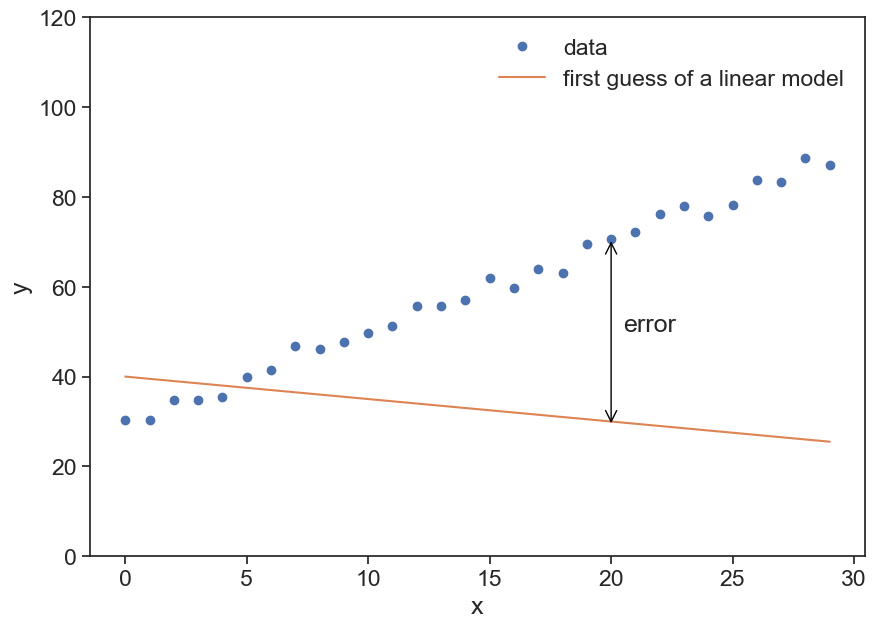

In [7]:
#| code-summary: "plot synthetic data"
N = 30
x_data = np.arange(N)
a = 2.0
b = 30.0
noise = 6 * (np.random.random(N)-0.5)
y_data = a * x_data + b + noise

fig, ax = plt.subplots(figsize=(10,7))
ax.plot(x_data, y_data, 'o', label="data")
ax.plot(x_data, -0.5*x_data + 40, label="first guess of a linear model")

ax.annotate("",
            xy=(x_data[20], y_data[20]), xycoords='data',
            xytext=(x_data[20], 29), textcoords='data',
            size=20,
            arrowprops=dict(arrowstyle="<->",
                            color="black",
                            connectionstyle="arc3"),
            )
ax.text(20.5, 50, "error")
ax.legend(frameon=False)
ax.set(xlabel="x",
       ylabel="y",
       ylim=[0,120]);

Our guess doesn't look good. We used the model

$$
y = ax + b
$$

where $a=-0.5$ and $b=40$.

We will adjust these two parameters by minimizing the mean error between each data point and the model (straight line). We need to minimize the following expression:

$$
\begin{split}
MSE &= \text{mean}(\text{error}^2) \\
MSE &= \frac{1}{N}\sum_{i=1}^N\text{error}^2 \\
MSE &= \frac{1}{N}\sum_{i=1}^N\large( \text{measured} - \text{modelled} \large)^2 \\
MSE &=  \frac{1}{N}\sum_{i=1}^N \large[ y_i - (a\cdot x_i +b) \large]^2
\end{split}
$$

The $MSE$ is a function of $a$ and $b$. For every set of values $(a,b)$, $MSE$ has value, so you can imagine a surface in the $(a,b)$ plane. 

In [8]:
#| code-summary: "define useful funcitons"
def compute_mse(y_measured, y_predicted):
    MSE = np.mean(
        (y_measured - y_predicted)**2
    )
    return MSE

def linear_model(x, a, b):
    return a*x + b

def gradient_descent(x, y, a, b, learning_rate):
    # linear model
    y_predicted = a * x + b
    error = y - y_predicted
    # partial derivatives
    da = np.mean(-2 * x * error)
    db = np.mean(-2 * error)
    # update a and b. minus sign because gradient points to direction
    # of maximal growth, we want to minimize MSE, not maximize
    a = a - da * learning_rate
    b = b - db * learning_rate
    mse = compute_mse(y, y_predicted)
    return a, b, mse


In [9]:
#| code-summary: "compute MSE landscape"
A_vec = np.linspace(-1, 5, 100)
B_vec = np.linspace(0, 60, 100)
A_mesh, B_mesh = np.meshgrid(A_vec, B_vec)
MSE_mesh = np.zeros_like(A_mesh)
for i in range(100):
    for j in range(100):
        Y_predicted_mesh = linear_model(x_data,
                                        A_mesh[i, j],
                                        B_mesh[i, j])
        MSE_mesh[i, j] = compute_mse(y_data, Y_predicted_mesh)

MSE_mesh_log = np.log(MSE_mesh)

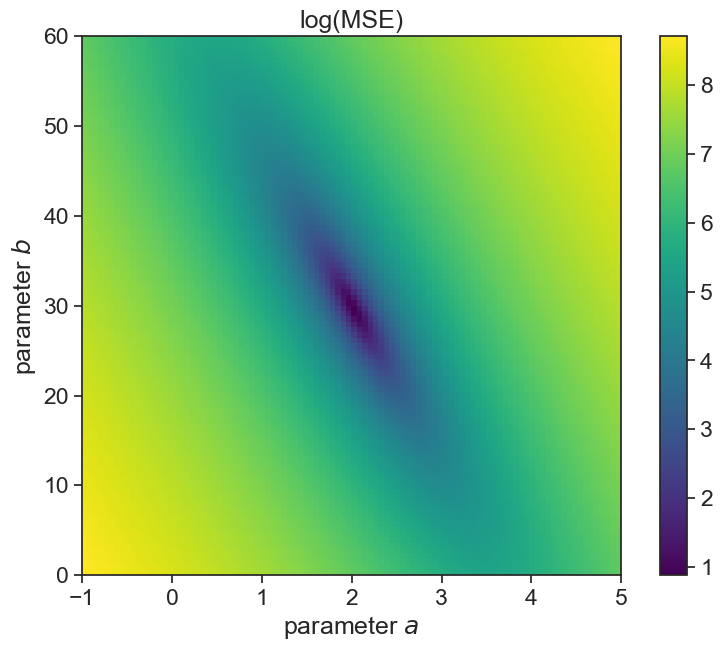

In [10]:
#| code-summary: "plot landscape"
fig, ax = plt.subplots(figsize=(10,7))
A_min = A_vec[0]; A_max = A_vec[-1];
B_min = B_vec[0]; B_max = B_vec[-1];
asp = (A_max - A_min) / (B_max - B_min)
cax = ax.imshow(MSE_mesh_log, extent=[A_min, A_max, B_min, B_max],
                origin='lower', cmap='viridis', aspect = asp)
fig.colorbar(cax)
ax.set(xlabel=r"parameter $a$",
       ylabel=r"parameter $b$",
       title="log(MSE)");

The gradient of $MSE$ is:

$$
\nabla MSE = \frac{\partial}{\partial a}MSE\; \widehat{a} + \frac{\partial}{\partial b}MSE\; \widehat{b}
$$

Taking the partial derivatives:

$$
\begin{split}
\frac{\partial}{\partial a}MSE &= \frac{1}{N}\sum_{i=1}^N (-2x_i)\large[ y_i - (a\cdot x_i +b)\large] \\
 &= \text{mean}\large[ (-2x_i) \cdot \large( \text{measured} - \text{modelled} \large) \large]  \\
\frac{\partial}{\partial b}MSE &= \frac{1}{N}\sum_{i=1}^N (-2) \large[y_i - (a\cdot x_i +b)\large] \\
 &= \text{mean}\large[ (-2) \cdot \large( \text{measured} - \text{modelled} \large) \large]
\end{split}
$$

In [11]:
#| code-summary: "optimize parameters using gradient descent"
lr = 1.0e-3
n_iterations = 30000
a_fit = np.zeros(n_iterations)
b_fit = np.zeros(n_iterations)
mse_fit = np.zeros(n_iterations)
a_fit[0] = -0.5
b_fit[0] = 40.0
for i in np.arange(1, n_iterations):
    a_fit[i], b_fit[i], mse_fit[i] = gradient_descent(x=x_data, y=y_data, a=a_fit[i-1], b=b_fit[i-1], learning_rate=lr)
print(f"best fit: a={a_fit[-1]:.2f}, b={b_fit[-1]:.2f}")

best fit: a=2.03, b=29.60


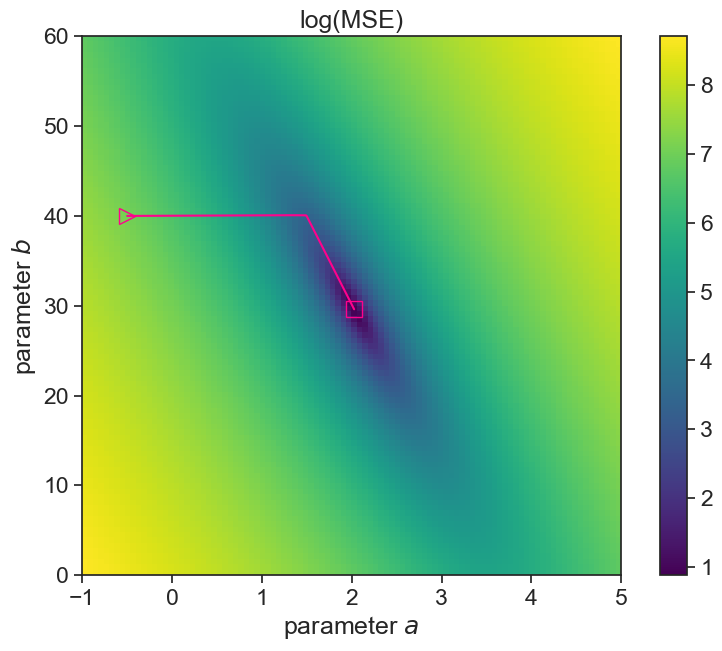

In [12]:
#| code-summary: "plot landscape and optimization path"
fig, ax = plt.subplots(figsize=(10,7))
A_min = A_vec[0]; A_max = A_vec[-1];
B_min = B_vec[0]; B_max = B_vec[-1];
asp = (A_max - A_min) / (B_max - B_min)
cax = ax.imshow(MSE_mesh_log, extent=[A_min, A_max, B_min, B_max],
                origin='lower', cmap='viridis', aspect = asp)
fig.colorbar(cax)

ax.plot(a_fit, b_fit, color="xkcd:hot pink")
ax.plot(a_fit[0], b_fit[0], linestyle='None', marker='>', markerfacecolor='none', markeredgecolor='xkcd:hot pink', markersize=12)
ax.plot(a_fit[-1], b_fit[-1], linestyle='None', marker='s', markerfacecolor='none', markeredgecolor='xkcd:hot pink', markersize=12)

ax.set(xlabel=r"parameter $a$",
       ylabel=r"parameter $b$",
       title="log(MSE)");

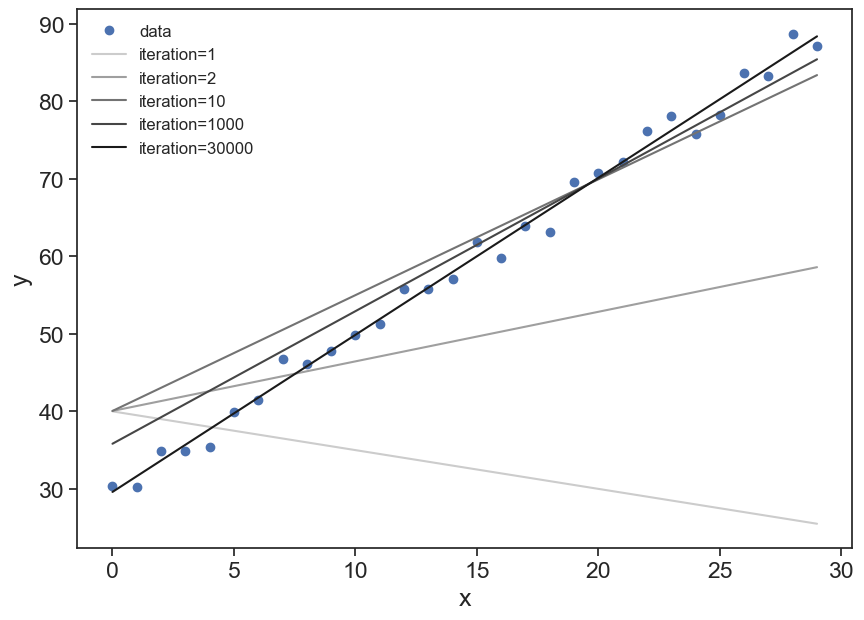

In [13]:
#| code-summary: "plot incremental improvement of the model"

fig, ax = plt.subplots(figsize=(10,7))
ax.plot(x_data, y_data, 'o', label="data")

iter_list = [1, 2, 10, 1000, 30000]
color_list = np.linspace(0.8, 0.1, len(iter_list))

for i in range(len(iter_list)):    
    ax.plot(x_data, a_fit[iter_list[i]-1] * x_data + b_fit[iter_list[i]-1],
            label=f"iteration={iter_list[i]:d}",
            color=[color_list[i]]*3
            )
ax.set(xlabel="x",
       ylabel="y")
ax.legend(frameon=False, fontsize=12);

### learning rate

The learning rate multiplies the gradient (partial derivatives in each parameter direction), therefore by playing with its values, we can converge slower or faster to the optimal solution we are seeking. There is a tradeoff in play here. If the learning curve is too small, we will have to run a lot of simulations steps to converge to the desired solution. On the other hand, if the learning rate is too large, the algorithm might not be able to converge to the region of the parameter space with the lowest MSE.

In [14]:
#| code-summary: "optimize parameters using gradient descent"
lr = 1.4e-3
n_iterations = 5000
a_fit_2 = np.zeros(n_iterations)
b_fit_2 = np.zeros(n_iterations)
mse_fit_2 = np.zeros(n_iterations)
a_fit_2[0] = -0.5
b_fit_2[0] = 40.0
for i in np.arange(1, n_iterations):
    a_fit_2[i], b_fit_2[i], mse_fit_2[i] = gradient_descent(x=x_data, y=y_data, a=a_fit_2[i-1], b=b_fit_2[i-1], learning_rate=lr)
# print(f"best fit: a={a_fit_2[-1]:.2f}, b={b_fit_2[-1]:.2f}")

best fit: a=2.01, b=29.87


In [15]:
#| code-summary: "optimize parameters using gradient descent"
lr = 5e-4
n_iterations = 5000
a_fit_3 = np.zeros(n_iterations)
b_fit_3 = np.zeros(n_iterations)
mse_fit_3 = np.zeros(n_iterations)
a_fit_3[0] = -0.5
b_fit_3[0] = 40.0
for i in np.arange(1, n_iterations):
    a_fit_3[i], b_fit_3[i], mse_fit_3[i] = gradient_descent(x=x_data, y=y_data, a=a_fit_3[i-1], b=b_fit_3[i-1], learning_rate=lr)
# print(f"best fit: a={a_fit_3[-1]:.2f}, b={b_fit_3[-1]:.2f}")

best fit: a=1.88, b=32.44


In [16]:
#| code-summary: "optimize parameters using gradient descent"
lr = 3.5e-3
n_iterations = 5000
a_fit_4 = np.zeros(n_iterations)
b_fit_4 = np.zeros(n_iterations)
mse_fit_4 = np.zeros(n_iterations)
a_fit_4[0] = -0.5
b_fit_4[0] = 40.0
for i in np.arange(1, n_iterations):
    a_fit_4[i], b_fit_4[i], mse_fit_4[i] = gradient_descent(x=x_data, y=y_data, a=a_fit_4[i-1], b=b_fit_4[i-1], learning_rate=lr)
# print(f"best fit: a={a_fit_4[-1]:.2f}, b={b_fit_4[-1]:.2f}")

best fit: a=1551.68, b=108.47


/var/folders/c3/7hp0d36n6vv8jc9hm2440__00000gn/T/ipykernel_86050/3729129073.py:12: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set(ylim=[0, 50],


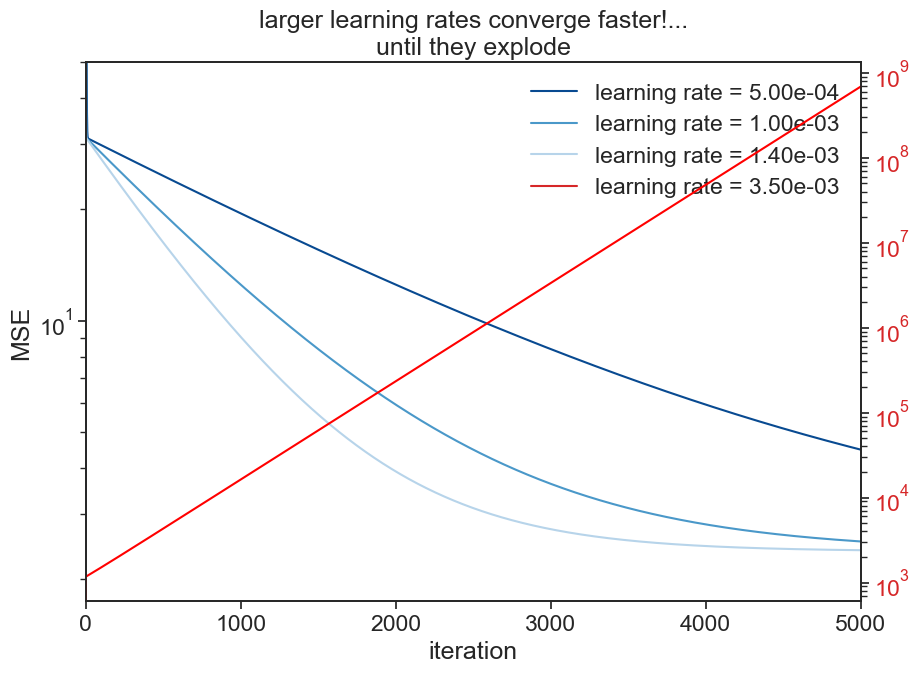

In [17]:
fig, ax = plt.subplots(figsize=(10,7))

cmap = plt.cm.Blues
colors = [cmap(0.9), cmap(0.6), cmap(0.3)]

ax.plot((mse_fit_3), label=f"learning rate = {5e-4:.2e}", color=colors[0])
ax.plot((mse_fit), label=f"learning rate = {1.0e-3:.2e}", color=colors[1])
ax.plot((mse_fit_2), label=f"learning rate = {1.4e-3:.2e}", color=colors[2])
ax.plot([], [], label=f"learning rate = {3.5e-3:.2e}", color="tab:red")

ax.set_yscale('log')
ax.set(ylim=[0, 50],
       xlim=[0, 5000],
       xlabel="iteration",
       ylabel="MSE",
       title="larger learning rates converge faster!...\nuntil they explode")

ax2 = ax.twinx()
ax2.plot((mse_fit_4), color="red")
ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax.legend(frameon=False);

This way of finding the optimal set of parameters is the first and very simplest method. Much more sophisticated methods were developed throughout the years. This basic idea of finding the optimal values for a list of parameters is the basic idea behind machine learning methods.

### local and global minima

The landscape we saw in the example above was well behaved, and we easily converged to a reasonable solution. Sometimes the landscape is more convoluted, and we might get stuck on local minima, depending on the initial conditions for the parameters. In that case, we need to help the algorithm by providing it with other initial guesses for the parameters.

<iframe src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*47skUygd3tWf3yB9A10QHg.gif" width="500" height="500" frameborder="0" allowfullscreen></iframe>

<iframe src="https://upload.wikimedia.org/wikipedia/commons/a/a3/Gradient_descent.gif" width="500" height="500" frameborder="0" allowfullscreen></iframe>

## Green & Ampt

$$f = \frac{A}{F} + B$$

where

* $A = K_\text{sat}\cdot|\psi_f|\cdot \left( \phi - \theta_0 \right)$
* $B= K_\text{sat}$

Write a function that calculates the cumulative of the infiltration rate.

$$
F(t) = \int_0^t f(t) \text{ d}t
$$

Use numpy's `trapz` function, that implements the "trapezoidal rule"

![](640px-Composite_trapezoidal_rule_illustration.png)

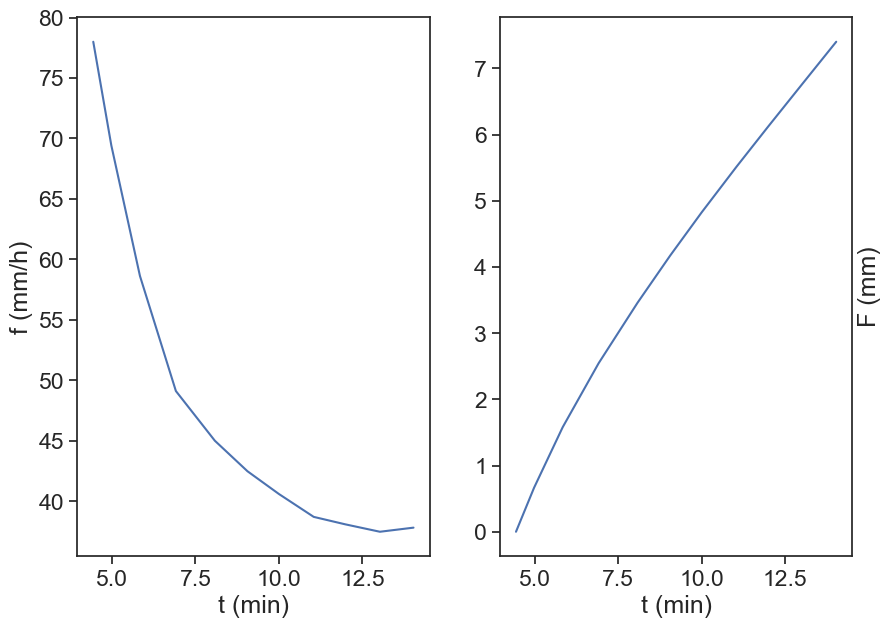

In [18]:
#| code-fold: false
def cumulative_F(t, f):
    F = np.array([0])
    t = t/60 # convert minute to hour
    for i in np.arange(2,len(t)+1):
        area = np.trapz(f[:i], t[:i])
        F = np.concatenate([F, [area]])
    return F

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7))
t, f = d1[:,0], d1[:,1]
F = cumulative_F(t, f)
ax1.plot(t, f, label="f, rate")
ax2.plot(t, F, label="F, cumulative")
ax1.set(xlabel="t (min)",
        ylabel="f (mm/h)")
ax2.set(xlabel="t (min)",
        ylabel="F (mm)")
ax2.yaxis.set_label_position("right")

Plot $f$ as a function of $F$. Try to guess $A$ and $B$ that give reasonable results.

/var/folders/c3/7hp0d36n6vv8jc9hm2440__00000gn/T/ipykernel_86050/768544551.py:7: RuntimeWarning: divide by zero encountered in divide
  ax.plot(F, A/F + B, 'o')


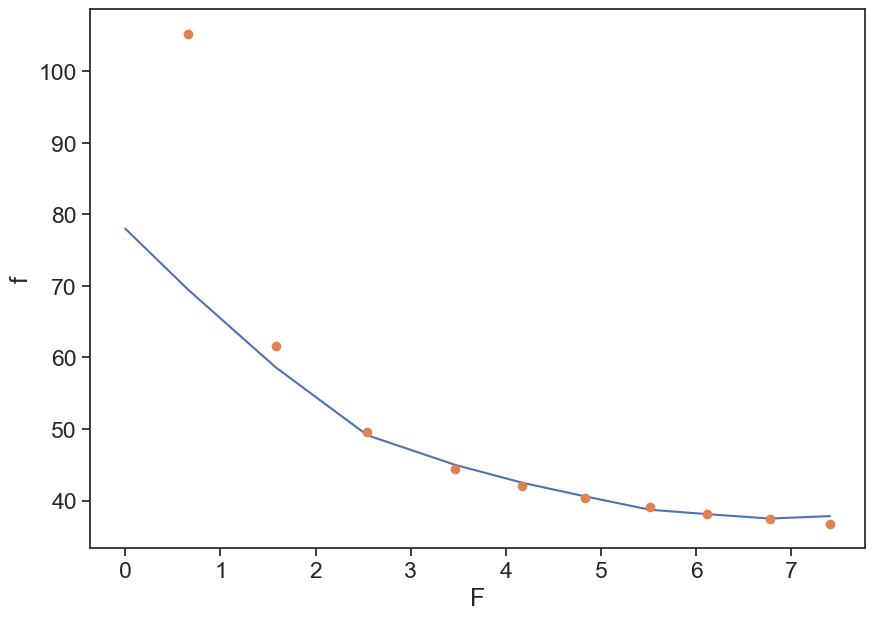

In [19]:
#| code-fold: false
fig, ax = plt.subplots(figsize=(10,7))
t, f = d1[:,0], d1[:,1]
F = cumulative_F(t, f)
ax.plot(F, f)
A=50; B=30;
ax.plot(F, A/F + B, 'o')
ax.set(xlabel="F",
       ylabel="f");

Use the `curve_fit` to find the optimal values for $A$ and $B$.

[24.12368526 36.34242813]


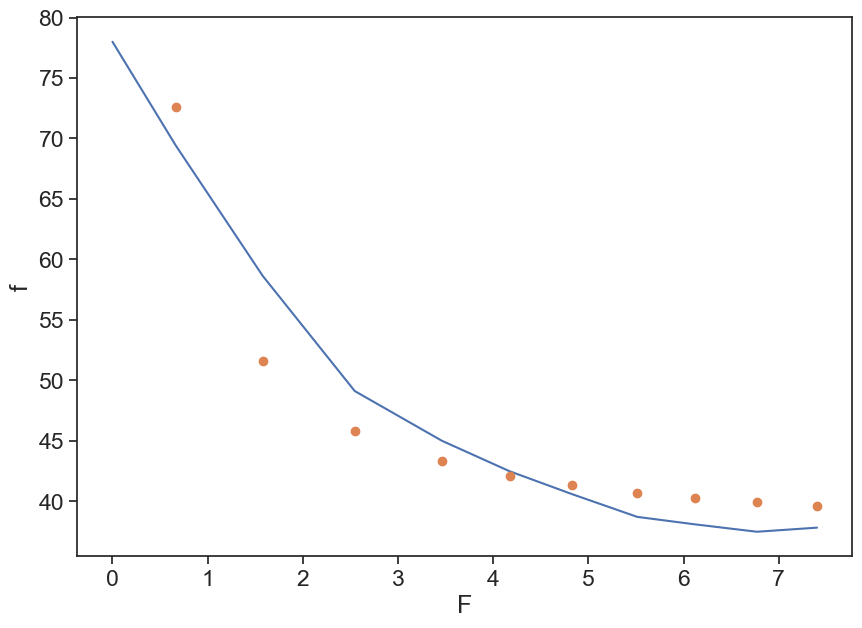

In [20]:
#| code-fold: false
def G_and_A(F, A, B):
    return A/F + B

popt, pcov = curve_fit(f=G_and_A,     # model function
                       xdata=F[1:],       # x data
                       ydata=f[1:],       # y data
                       p0=(50, 30),   # initial guess of the parameters
                      )

# popt, pcov = curve_fit(G_and_A, F[1:], f[1:], p0=(50, 30))  # p0 = initial guess
print(popt)

fig, ax = plt.subplots(figsize=(10,7))
ax.plot(F, f)
ax.plot(F[1:], popt[0]/F[1:] + popt[1], 'o')
ax.set(xlabel="F",
       ylabel="f");

## Homework

Go to [Soil Texture Calculator](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/soils/survey/?cid=nrcs142p2_054167), estimate the texture of "standard soil" in Nassif & Wilson, 1975.